In [2]:

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm


try:
    from src.net import Net, train, test, get_dataloader
    from src.preprocessing import Deskewing,  split_into_cells
    from src.util import check_sudoku, sudoku, sudoku2, get_pics_path, get_gray_images
    
except ModuleNotFoundError:
    import httpimport
    with httpimport.github_repo(
            'iCarrrot', 
            'nn_sudoku_project',
            branch='master'
    ):
        from src.net import Net, train, test, get_dataloader
        from src.preprocessing import Deskewing,  split_into_cells
        from src.util import check_sudoku, sudoku, sudoku2, get_pics_path, get_gray_images


%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


### TODO

* dzielenie datasetu
* downsampling obrazków
* metoda szybko printująca obrazek
* wycinanie diagramu z modyfikowanym thresholdem
* spięcie całości w metodę
* cięcie diagramu
* import sieci do rozpoznawania liczb
* konsumpcja outputu sieci

* solver: https://towardsdatascience.com/solving-sudoku-with-convolution-neural-network-keras-655ba4be3b11 
* solving krok po kroku: RNN?
* jakies ładne ogarnięcie całości

False

In [3]:
pics_path = get_pics_path()
gray_images = get_gray_images(pics_path)
gray_images.shape

/Users/michal/studia/nn_sudoku_project/venv/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


KeyError: 'CLOUDSDK_CONFIG'

## Dataset

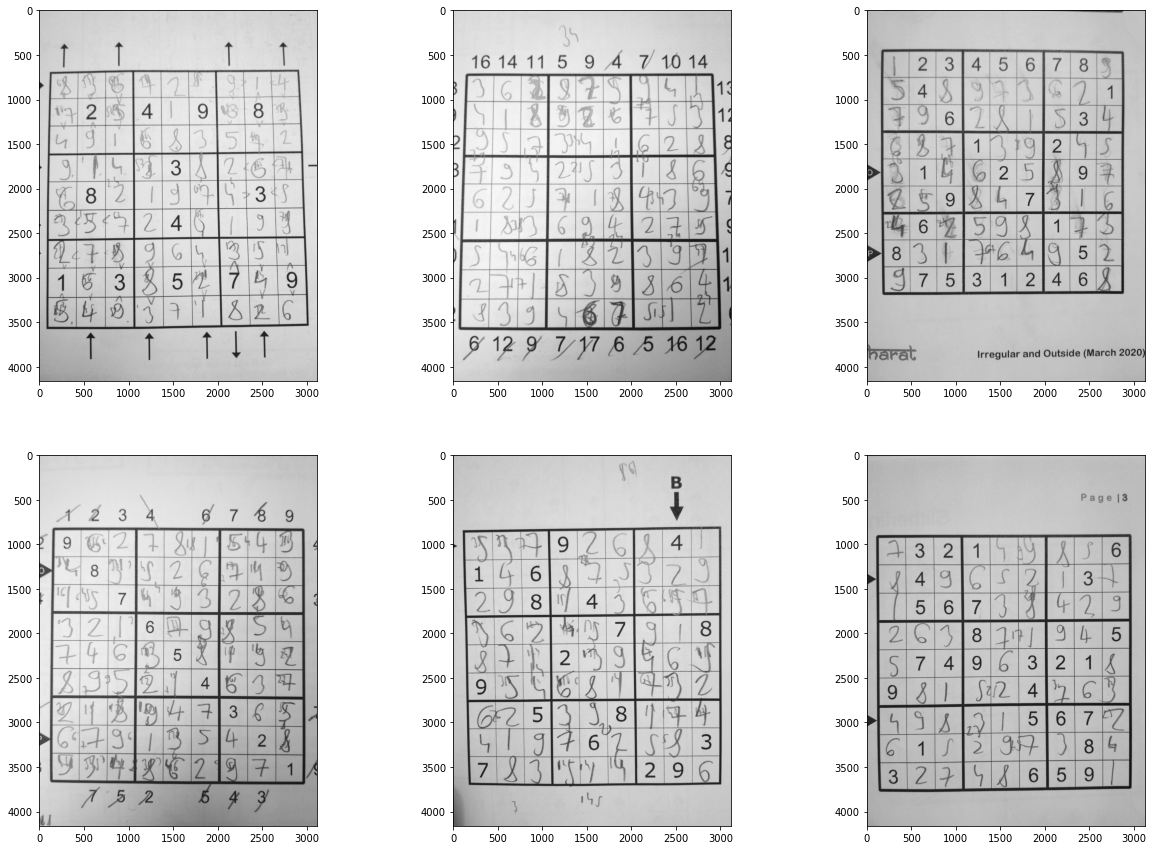

In [ ]:
plt.figure(figsize=(21, 15))
for idx, img in enumerate(gray_images[np.random.choice(gray_images.shape[0], size=6)]):
    plt.subplot(2, 3, idx + 1)
    imgplot = plt.imshow(img, cmap='gray')
plt.show()


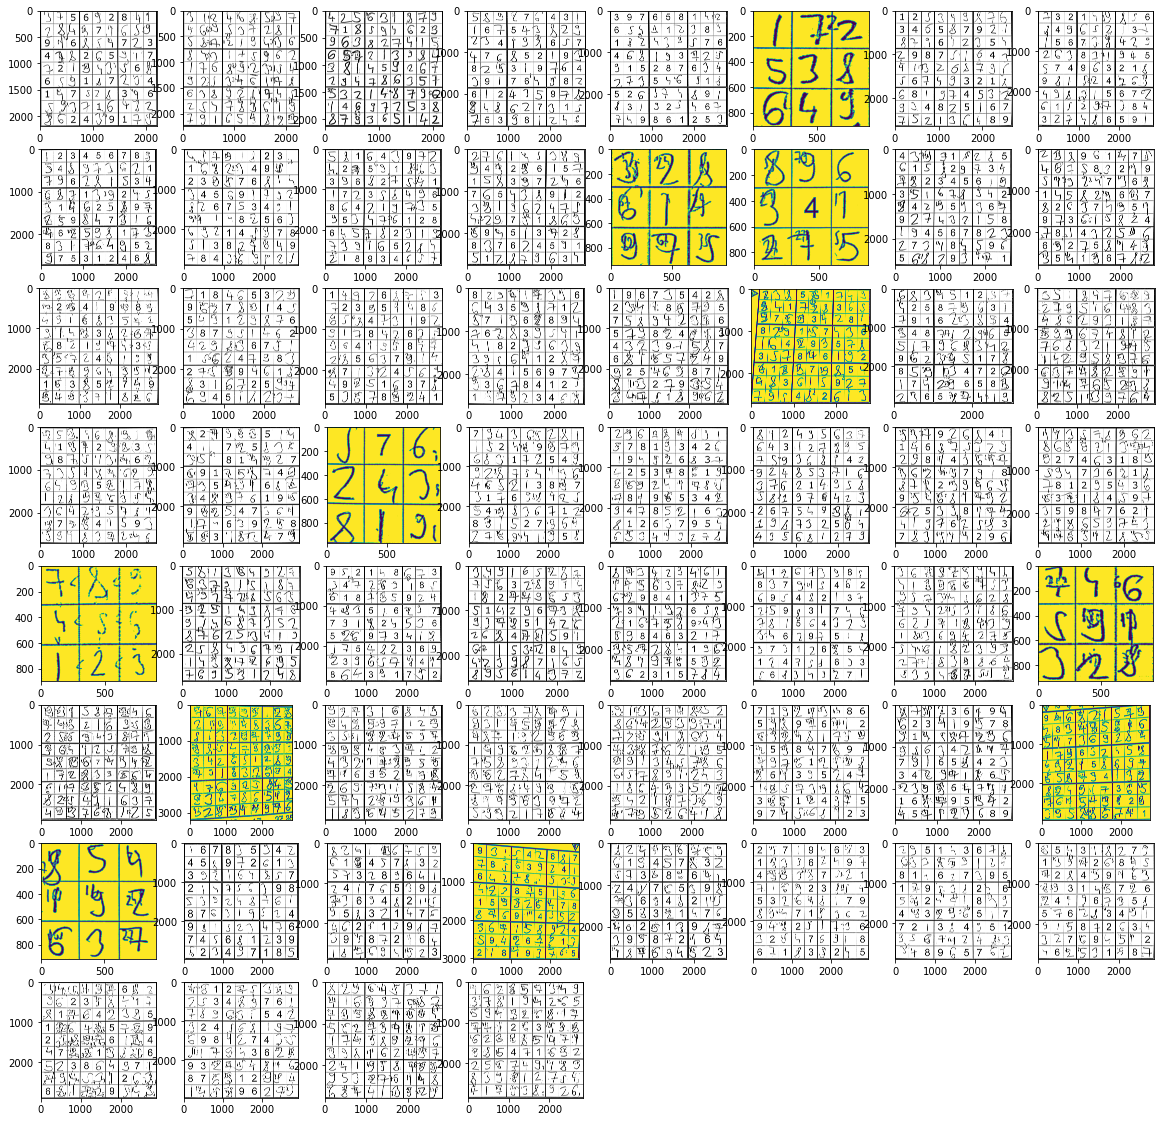

In [ ]:
deskewed_imgs = []
plt.figure(figsize=(20, 20))
for i in tqdm(range(len(gray_images))):
    deskewed = Deskewing(gray_images[i])._deskew()
    plt.subplot(8, 8, i + 1)
    if deskewed.shape[0] < 2000 or deskewed.shape[1] < 2000 or abs(deskewed.shape[0] - deskewed.shape[1]) > 100:
        plt.imshow(deskewed)
    else:
        plt.imshow(deskewed, cmap='gray')
        
    deskewed_imgs.append(deskewed)

In [ ]:
digits = split_into_cells(deskewed_imgs[4])
plt.figure(figsize=(10,10))
for i in range(81):
    plt.subplot(9, 9, i + 1)
    plt.imshow(digits[i, :, :], cmap='gray', interpolation='none')



## Check sudoku corectness


In [ ]:
check_sudoku(sudoku), check_sudoku(sudoku2)

True

## Example NN
[PyTorch MNIST](https://github.com/pytorch/examples/blob/master/mnist/main.py)

In [ ]:
import torch
import torchvision


n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)



y = np.array([ 
    [2,3,8,9,6,1,4,7,5], 
    [4,6,7,5,8,3,2,1,9], 
    [5,1,9,2,4,7,3,6,8], 
    [1,4,5,8,2,9,6,3,7], 
    [8,2,6,3,7,4,9,5,1],
    [9,7,3,6,1,5,8,2,4],
    [7,8,1,4,3,2,5,9,6], 
    [6,9,2,7,5,8,1,4,3], 
    [3,5,4,1,9,6,7,8,2] ])

grid_dataloader = get_dataloader(digits, y, batch_size_test = batch_size_test )


model = Net()

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
train(model=model, device='cpu', train_loader=train_loader, epoch=30, optimizer=torch.optim.Adam(model.parameters()))


Train Epoch: 30 [0/60000 (0%)]	Loss: 2.292349
Train Epoch: 30 [6400/60000 (11%)]	Loss: 0.340384
Train Epoch: 30 [12800/60000 (21%)]	Loss: 0.327970
Train Epoch: 30 [19200/60000 (32%)]	Loss: 0.127610
Train Epoch: 30 [25600/60000 (43%)]	Loss: 0.073101
Train Epoch: 30 [32000/60000 (53%)]	Loss: 0.046204
Train Epoch: 30 [38400/60000 (64%)]	Loss: 0.123202
Train Epoch: 30 [44800/60000 (75%)]	Loss: 0.049112
Train Epoch: 30 [51200/60000 (85%)]	Loss: 0.087665
Train Epoch: 30 [57600/60000 (96%)]	Loss: 0.134980


In [ ]:

prediction = test(model=model, device='cpu', test_loader=grid_dataloader)
equal = prediction.reshape((9,9)) == y 
print(equal, equal.sum())





Test set: Average loss: 107.7965, Accuracy: 50/81 (62%)

[[False False False False False False False False False]
 [False False False False False False False False False]
 [False False False  True False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False  True]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False  True False False False False False False]
 [False False  True  True False False False False False]] 5
